In [2]:
# Colab setup
!pip -q install opencv-python-headless nibabel solt

# AI in Health Technologies D - Final Project
This notebook implements the project for AI in Health Technologies D.

Student Name: *Niccolò Salvi*  
Student Number: *103547758*  
Group: *Individual*

## Imports


In [ ]:
import gc
import os
import random
import sys
from concurrent.futures import ProcessPoolExecutor
from dataclasses import dataclass
from pathlib import Path
import multiprocessing as mp

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import solt
import solt.transforms as slt
from tqdm.auto import tqdm

In [ ]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

cv2.ocl.setUseOpenCL(False)
cv2.setNumThreads(0)

train_trf = solt.Stream([
    slt.Resize((256, 256)),
    slt.Flip(p=0.5, axis=1),
    slt.Crop((224, 224), crop_mode="r"),
    slt.GammaCorrection(gamma_range=0.1, p=1),
])

val_trf = solt.Stream([
    slt.Resize((256, 256)),
])

@dataclass
class Cfg:
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    in_channels: int = 3
    num_classes: int = 2

    dataset_train_cls: type | None = None
    dataset_val_cls: type | None = None

    optimizer_cls = torch.optim.AdamW
    loss_fn = torch.nn.CrossEntropyLoss()

    lr: float = 1e-3
    wd: float = 5e-5
    num_epochs: int = 1
    n_workers: int = 0
    train_bs: int = 2
    val_bs: int = 2

    lr_drop_milestones: list[int] | None = None
    class_names: list[str] | None = None

    train_trf: solt.Stream | None = None
    val_trf: solt.Stream | None = None

    def __post_init__(self):
        if self.lr_drop_milestones is None:
            self.lr_drop_milestones = [30]
        if self.class_names is None:
            self.class_names = ["BG", "FG"]
        self.num_classes = len(self.class_names)

        if self.train_trf is None:
            self.train_trf = train_trf
        if self.val_trf is None:
            self.val_trf = val_trf

        if self.dataset_train_cls is None:
            self.dataset_train_cls = globals().get("KneeSegmentationDataset")
        if self.dataset_val_cls is None:
            self.dataset_val_cls = globals().get("KneeSegmentationDataset")
        if self.dataset_train_cls is None or self.dataset_val_cls is None:
            raise ValueError("Dataset classes are not defined yet.")

class CfgHighRes(Cfg):
    train_trf = solt.Stream([
        slt.Flip(p=0.5, axis=1),
        slt.Crop((320, 320), crop_mode="r"),
        slt.GammaCorrection(gamma_range=0.1, p=1),
    ])

    val_trf = solt.Stream([])

class CfgVol(Cfg):
    dataset_val_cls: type | None = None
    val_bs = 1

    def __post_init__(self):
        super().__post_init__()
        self.dataset_val_cls = globals().get("KneeSegmentationDatasetVol")
        if self.dataset_val_cls is None:
            raise ValueError("KneeSegmentationDatasetVol is not defined yet.")

## Dataset


### Data loading classes


In [ ]:
class KneeSegmentationDataset(Dataset):
    """Slice-wise dataset with paired SOLT transforms."""

    def __init__(self, df: pd.DataFrame, transforms: solt.Stream | None):
        self.dataset = df.reset_index(drop=True)
        self.trf = transforms

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> dict:
        entry = self.dataset.iloc[idx]
        img = cv2.imread(str(entry.img), cv2.IMREAD_COLOR)
        mask = cv2.imread(str(entry.segmask), cv2.IMREAD_GRAYSCALE)
        if img is None or mask is None:
            raise FileNotFoundError(f"Missing image/mask for index {idx}")

        if self.trf is not None:
            res = self.trf({"image": img, "mask": mask}, return_torch=False)
            img, mask = res.data

        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.int64)

        img_t = torch.from_numpy(img).permute(2, 0, 1)
        mask_t = torch.from_numpy(mask).unsqueeze(0)

        return {"image": img_t, "mask": mask_t}

class KneeSegmentationDatasetVol(Dataset):
    """Volume-wise dataset that groups slices by scan."""

    def __init__(self, df: pd.DataFrame, transforms: solt.Stream | None, load_mask: bool = True):
        super().__init__()
        self.df = df
        self.trf = transforms
        self.load_mask = load_mask

        self.scans = []
        for _, g in self.df.groupby(["ID", "SIDE", "VISIT"]):
            g = g.sort_values(by="slice_idx").reset_index(drop=True)
            self.scans.append(g)

    def __len__(self) -> int:
        return len(self.scans)

    def __getitem__(self, index: int) -> dict:
        return self.load_volume(self.scans[index], self.trf, load_mask=self.load_mask)

    @staticmethod
    def _to_chw_tensor(img: np.ndarray | torch.Tensor) -> torch.Tensor:
        if isinstance(img, np.ndarray):
            tensor = torch.from_numpy(img)
            if tensor.dim() == 3 and tensor.shape[-1] in (1, 3):
                tensor = tensor.permute(2, 0, 1)
            tensor = tensor.float() / 255.0
            return tensor

        if torch.is_tensor(img):
            tensor = img.float()
            if tensor.dim() == 3 and tensor.shape[-1] in (1, 3):
                tensor = tensor.permute(2, 0, 1)
            if tensor.max() > 1.0:
                tensor = tensor / 255.0
            return tensor

        raise TypeError("Unsupported image type for volume loading")

    @staticmethod
    def _to_hw_long(mask: np.ndarray | torch.Tensor) -> torch.Tensor:
        if isinstance(mask, np.ndarray):
            tensor = torch.from_numpy(mask)
        elif torch.is_tensor(mask):
            tensor = mask
        else:
            raise TypeError("Unsupported mask type for volume loading")

        if tensor.dim() == 3 and tensor.size(0) == 1:
            tensor = tensor.squeeze(0)
        return tensor.long()

    @staticmethod
    def load_volume(vol_df: pd.DataFrame, transform: solt.Stream | None, load_mask: bool = True) -> dict:
        images, masks = [], []
        for _, entry in vol_df.iterrows():
            img = cv2.imread(str(entry.img), cv2.IMREAD_COLOR)
            if img is None:
                raise FileNotFoundError(f"Missing image: {entry.img}")
            images.append(img)

            if load_mask:
                mask = cv2.imread(str(entry.segmask), cv2.IMREAD_GRAYSCALE)
                if mask is None:
                    raise FileNotFoundError(f"Missing mask: {entry.segmask}")
                masks.append(mask)

        if transform is not None:
            if load_mask:
                res = transform({"images": images, "masks": masks})
            else:
                res = transform({"images": images})
            images = res["images"]
            if load_mask:
                masks = res["masks"]

        scan = torch.stack([KneeSegmentationDatasetVol._to_chw_tensor(img) for img in images], dim=0)
        if load_mask:
            mask = torch.stack([KneeSegmentationDatasetVol._to_hw_long(m) for m in masks], dim=0)
        else:
            mask = None

        return {"scan": scan, "mask": mask}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = Path("drive/MyDrive/Colab Notebooks/Cartilage_segmentation_data_AI4Health/")

Mounted at /content/drive


In [11]:
ds = []
for img in base_dir.glob("*_img.nii.*"):
    patient, fu, side, _ = img.name.split("_")
    ds.append({"img": img, "segmask": img.parent / img.name.replace("_img", "_mask"), "ID": patient, "VISIT": fu, "SIDE": side})
ds = pd.DataFrame(ds)
ds.head()

,img,segmask,ID,VISIT,SIDE
0,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,9597990,00m,R
1,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,9967358,12m,R
2,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,9663706,12m,R
3,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,9500390,12m,R
4,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,9992358,00m,R


### Recreate slice caching and data indexing
Convert 3D volumes into cached 2D slices and build a slice-level index.

In [ ]:
def vis_slice(img, lp=0, hp=99.9):
    # Normalize a slice to uint8 for PNG storage.
    img_float = img.astype(np.float32)
    low = np.percentile(img_float, lp)
    high = np.percentile(img_float, hp)
    img_norm = (img_float - low) / (high - low)
    img_norm = np.clip(img_norm, 0, 1)
    return (img_norm * 255).astype(np.uint8)

def orient_slice(slice_2d):
    # Match the orientation used in assignment 3 visualizations.
    slice_2d = np.rot90(slice_2d, k=3)
    slice_2d = np.fliplr(slice_2d)
    return slice_2d

In [ ]:
dataset_local_dir = Path("/content/dataset_slices/")

(dataset_local_dir / "images").mkdir(exist_ok=True, parents=True)
(dataset_local_dir / "masks").mkdir(exist_ok=True, parents=True)

def process_row(item):
    idx, row = item

    img = nib.load(row.img)
    mask = nib.load(row.segmask)

    img_data = img.get_fdata()
    mask_data = mask.get_fdata()

    out_rows = []

    # iterate over sagittal slices (axis 0)
    for sl in range(img_data.shape[0]):
        # IMAGE
        sl_img = img_data[sl, :, :] # sagittal slice
        sl_img = vis_slice(sl_img) # contrast / percentile scaling
        # geometric transforms
        sl_img = np.rot90(sl_img, k=3)
        sl_img = np.fliplr(sl_img)

        # MASK
        sl_mask = mask_data[sl, :, :]
        sl_mask = np.rot90(sl_mask, k=3)
        sl_mask = np.fliplr(sl_mask)

        sl_mask = (sl_mask > 0).astype(np.uint8) # force {0,1}

        # common filename for image + mask
        slice_name = f"{row.ID}_{row.VISIT}_{row.SIDE}_slice{sl:03d}.png"
        img_path  = dataset_local_dir / "images" / slice_name
        mask_path = dataset_local_dir / "masks" / slice_name

        # save with OpenCV (grayscale)
        cv2.imwrite(str(img_path), sl_img)
        cv2.imwrite(str(mask_path), sl_mask)

        out_rows.append({
            "ID": row.ID,
            "SIDE": row.SIDE,
            "VISIT": row.VISIT,
            "slice_idx": sl,
            "img": str(img_path),
            "segmask": str(mask_path),
        })

    return out_rows

# parallel processing over all rows of ds
all_rows = []

# ds.iterrows() yields (index, row) pairs, which we pass to process_row
with ProcessPoolExecutor(max_workers=mp.cpu_count()) as ex:
    for result in ex.map(process_row, ds.iterrows()):
        all_rows.extend(result)

slice_ds = pd.DataFrame(all_rows)

In [16]:
slice_ds.head()

,ID,SIDE,VISIT,slice_idx,img,segmask
0,9597990,R,00m,0,/content/dataset_slices/images/9597990_00m_R_s...,/content/dataset_slices/masks/9597990_00m_R_sl...
1,9597990,R,00m,1,/content/dataset_slices/images/9597990_00m_R_s...,/content/dataset_slices/masks/9597990_00m_R_sl...
2,9597990,R,00m,2,/content/dataset_slices/images/9597990_00m_R_s...,/content/dataset_slices/masks/9597990_00m_R_sl...
3,9597990,R,00m,3,/content/dataset_slices/images/9597990_00m_R_s...,/content/dataset_slices/masks/9597990_00m_R_sl...
4,9597990,R,00m,4,/content/dataset_slices/images/9597990_00m_R_s...,/content/dataset_slices/masks/9597990_00m_R_sl...


## Patient splits

Create patient-level folds without leakage and select a reference fold for downstream sanity checks.

In [ ]:
def make_patient_folds(slice_df, n_splits=5, seed=SEED):
    patients = slice_df["ID"].astype(str) + "_" + slice_df["SIDE"]
    unique_patients = patients.unique()

    rng = np.random.default_rng(seed)
    shuffled = unique_patients.copy()
    rng.shuffle(shuffled)

    patient_folds = np.array_split(shuffled, n_splits)
    folds = []
    for fold_idx, val_patients in enumerate(patient_folds):
        val_patients = set(val_patients.tolist())
        train_patients = set(shuffled.tolist()) - val_patients

        train_df = slice_df[patients.isin(train_patients)].reset_index(drop=True)
        val_df = slice_df[patients.isin(val_patients)].reset_index(drop=True)

        folds.append({
            "fold": fold_idx,
            "train_df": train_df,
            "val_df": val_df,
            "train_patients": train_patients,
            "val_patients": val_patients,
        })

    return folds

folds = make_patient_folds(slice_ds, n_splits=5)
for fold in folds:
    print(
        f"Fold {fold['fold']}: "
        f"{len(fold['train_patients'])} train patients → {len(fold['train_df'])} slices, "
        f"{len(fold['val_patients'])} val patients → {len(fold['val_df'])} slices"
    )

reference_fold = folds[0]
train_df = reference_fold["train_df"]
val_df = reference_fold["val_df"]

Fold 0: 36 train patients → 10560 slices, 9 val patients → 2560 slices
Fold 1: 36 train patients → 10400 slices, 9 val patients → 2720 slices
Fold 2: 36 train patients → 10560 slices, 9 val patients → 2560 slices
Fold 3: 36 train patients → 10400 slices, 9 val patients → 2720 slices
Fold 4: 36 train patients → 10560 slices, 9 val patients → 2560 slices


### Sanity check
Ensure each fold has disjoint train/val patients and all patients are covered.

In [ ]:
all_patients = set()
for fold in folds:
    train_patients = fold["train_patients"]
    val_patients = fold["val_patients"]
    assert train_patients.isdisjoint(val_patients), "Train/val leakage in fold."
    all_patients.update(train_patients)
    all_patients.update(val_patients)

unique_patients = set((slice_ds["ID"].astype(str) + "_" + slice_ds["SIDE"]).unique())
assert all_patients == unique_patients, "Not all patients are covered by folds."

print("All folds are disjoint and cover the full patient set.")

All folds are disjoint and cover the full patient set.


### Minimal batch sanity check

Load a batch and confirm shapes + mask alignment.

In [ ]:
class SliceDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row.img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(row.segmask, cv2.IMREAD_GRAYSCALE)

        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).long()
        return {"image": img, "mask": mask}

train_ds = SliceDataset(train_df)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

batch = next(iter(train_loader))
images = batch["image"]
masks = batch["mask"]

print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)
assert images.shape[-2:] == masks.shape[-2:], "Image/mask spatial dimensions do not match."

Image batch shape: torch.Size([2, 3, 384, 384])
Mask batch shape: torch.Size([2, 384, 384])


### Sanity check
Visualize a single image/mask pair for alignment.

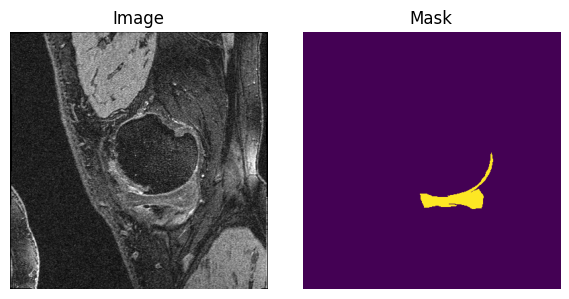

In [ ]:
img_np = images[0].permute(1, 2, 0).numpy()
mask_np = masks[0].numpy()

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(img_np)
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].imshow(mask_np, cmap="viridis")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## SDF targets

Convert each 2D hard mask slice into a signed distance field (inside negative, outside positive) with stable normalization/clipping.

In [ ]:
def hard_mask_to_sdf(mask, clip_value=20.0, normalize=True, eps=1e-6):
    """
    Convert a 2D hard mask into a signed distance field.
    Inside the mask is negative, outside is positive.
    """
    if torch.is_tensor(mask):
        mask_np = mask.detach().cpu().numpy()
    else:
        mask_np = np.asarray(mask)

    if mask_np.ndim == 3 and mask_np.shape[0] == 1:
        mask_np = mask_np[0]

    mask_bin = (mask_np > 0).astype(np.uint8)
    dist_out = cv2.distanceTransform(1 - mask_bin, cv2.DIST_L2, 5)
    dist_in = cv2.distanceTransform(mask_bin, cv2.DIST_L2, 5)
    sdf = dist_out - dist_in

    if clip_value is not None:
        sdf = np.clip(sdf, -clip_value, clip_value)
    if normalize:
        denom = np.max(np.abs(sdf)) + eps
        sdf = sdf / denom

    return sdf.astype(np.float32)

### Sanity check
Visualize SDFs for a few slices and confirm boundary values are near zero.


Slice 0: SDF min=-0.649, max=1.000, boundary mean |sdf|=0.055
Slice 1: SDF min=-0.600, max=1.000, boundary mean |sdf|=0.056


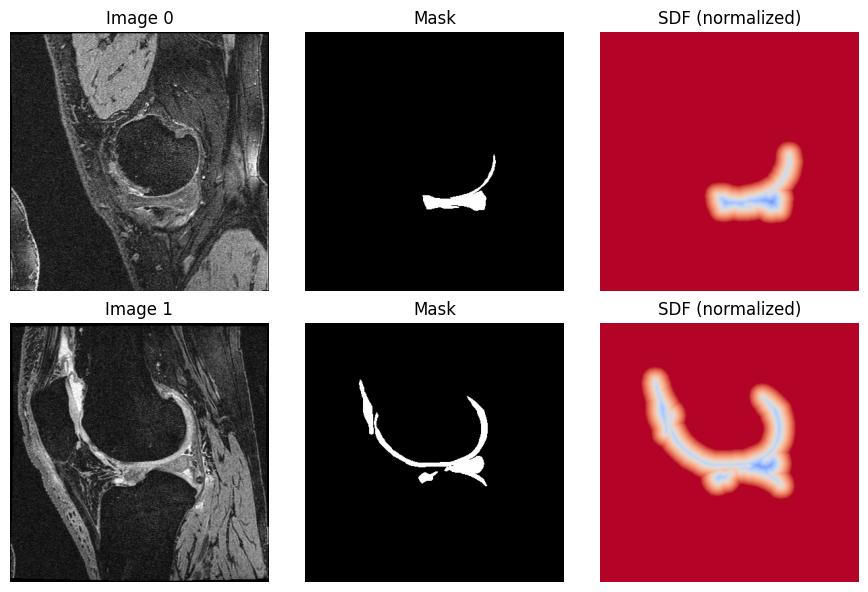

In [ ]:
def boundary_mask(binary_mask, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded = cv2.erode(binary_mask.astype(np.uint8), kernel, iterations=1)
    return (binary_mask.astype(np.uint8) - eroded).astype(bool)

num_slices = min(3, masks.shape[0])
fig, axes = plt.subplots(num_slices, 3, figsize=(9, 3 * num_slices))
if num_slices == 1:
    axes = np.expand_dims(axes, axis=0)

for i in range(num_slices):
    img_np = images[i].permute(1, 2, 0).numpy()
    mask_np = masks[i].numpy()

    sdf = hard_mask_to_sdf(mask_np, clip_value=20.0, normalize=True)

    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f"Image {i}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask_np, cmap="gray")
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis("off")

    im = axes[i, 2].imshow(sdf, cmap="coolwarm", vmin=-1, vmax=1)
    axes[i, 2].set_title("SDF (normalized)")
    axes[i, 2].axis("off")

    boundary = boundary_mask(mask_np > 0)
    boundary_mean = np.mean(np.abs(sdf[boundary])) if boundary.any() else np.nan
    print(f"Slice {i}: SDF min={sdf.min():.3f}, max={sdf.max():.3f}, boundary mean |sdf|={boundary_mean:.3f}")
    assert boundary_mean < 0.2, "Boundary is not close to zero after normalization."

plt.tight_layout()
plt.show()

## Model


### Define INR regression model
This subtask introduces a minimal coordinate-based INR MLP that outputs a single continuous value per coordinate, without classification activations.

In [ ]:
class INRMLP(nn.Module):
    """Minimal coordinate-based INR for scalar regression."""

    def __init__(
        self,
        in_features: int = 2,
        hidden_features: int = 128,
        hidden_layers: int = 4,
        out_features: int = 1,
    ):
        super().__init__()
        layers = [nn.Linear(in_features, hidden_features), nn.ReLU(inplace=True)]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_features, hidden_features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(hidden_features, out_features))
        self.net = nn.Sequential(*layers)

    def forward(self, coords: torch.Tensor) -> torch.Tensor:
        flat_coords = coords.view(-1, coords.shape[-1])
        out = self.net(flat_coords)
        return out.view(*coords.shape[:-1])

class SimpleSegmentationNet(nn.Module):
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

### Sanity check
Quick forward-pass checks for INR + CNN shapes.

In [ ]:
# INR forward-pass sanity check
coords = torch.rand(2, 8, 2) * 2 - 1 # (batch, points, xy) in [-1, 1]
inr = INRMLP(in_features=2, hidden_features=64, hidden_layers=3, out_features=1).to(Cfg().device)
with torch.no_grad():
    preds = inr(coords.to(Cfg().device))
print("Coords shape:", coords.shape)
print("Preds shape:", preds.shape)

tmp_root = Path("/tmp/seg_sanity")
tmp_root.mkdir(parents=True, exist_ok=True)

samples = []
for idx in range(4):
    img = (np.random.rand(256, 256, 3) * 255).astype(np.uint8)
    mask = (np.random.rand(256, 256) > 0.5).astype(np.uint8)
    img_path = tmp_root / f"img_{idx}.png"
    mask_path = tmp_root / f"mask_{idx}.png"
    cv2.imwrite(str(img_path), img)
    cv2.imwrite(str(mask_path), mask * 255)
    samples.append({
        "img": img_path,
        "segmask": mask_path,
        "ID": 0,
        "SIDE": "L",
        "VISIT": 0,
        "slice_idx": idx,
    })

df = pd.DataFrame(samples)
ds = KneeSegmentationDataset(df, val_trf)
sample = ds[0]
print("Image shape:", sample["image"].shape)
print("Mask shape:", sample["mask"].shape)

model = SimpleSegmentationNet(in_channels=3, num_classes=2).to(Cfg().device)
with torch.no_grad():
    logits = model(sample["image"].unsqueeze(0).to(Cfg().device))
print("Logits shape:", logits.shape)

Coords shape: torch.Size([2, 8, 2])
Preds shape: torch.Size([2, 8])
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])
Logits shape: torch.Size([1, 2, 256, 256])


## Losses and metrics

Define primary L1 loss and evaluation metrics for SDF regression.

In [ ]:
def l1_loss(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """Primary L1 loss for SDF regression."""
    return F.l1_loss(pred, target)

def sdf_mae(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return torch.mean(torch.abs(pred - target))

def sdf_rmse(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return torch.sqrt(torch.mean((pred - target) ** 2))

def sdf_to_mask(sdf: torch.Tensor, thresh: float = 0.0) -> torch.Tensor:
    return sdf < thresh

def dice_iou_from_sdf(
    pred_sdf: torch.Tensor,
    target_sdf: torch.Tensor,
    thresh: float = 0.0,
    eps: float = 1e-6,
) -> dict:
    pred_mask = sdf_to_mask(pred_sdf, thresh=thresh)
    target_mask = sdf_to_mask(target_sdf, thresh=thresh)

    intersection = (pred_mask & target_mask).sum().float()
    pred_sum = pred_mask.sum().float()
    target_sum = target_mask.sum().float()
    union = pred_sum + target_sum - intersection

    dice = (2 * intersection + eps) / (pred_sum + target_sum + eps)
    iou = (intersection + eps) / (union + eps)
    return {"dice": dice, "iou": iou}

### Tiny overfit sanity check

Overfit a single slice with INR + L1 loss to verify loss decreases.

In [ ]:
device = Cfg().device
slice_mask = masks[0].numpy()
sdf_target_np = hard_mask_to_sdf(slice_mask, clip_value=20.0, normalize=True)
sdf_target = torch.from_numpy(sdf_target_np).to(device)

height, width = sdf_target.shape
ys = torch.linspace(-1, 1, steps=height, device=device)
xs = torch.linspace(-1, 1, steps=width, device=device)
grid_y, grid_x = torch.meshgrid(ys, xs, indexing="ij")
coords = torch.stack([grid_x, grid_y], dim=-1)

inr = INRMLP(in_features=2, hidden_features=64, hidden_layers=3, out_features=1).to(device)
optimizer = torch.optim.Adam(inr.parameters(), lr=1e-3)
loss_fn = torch.nn.L1Loss()

loss_history = []
for step in range(60):
    optimizer.zero_grad()
    pred = inr(coords)
    loss = loss_fn(pred, sdf_target)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

print(f"Overfit loss: start={loss_history[0]:.4f}, end={loss_history[-1]:.4f}")
assert loss_history[-1] < loss_history[0], "Overfit sanity check failed: loss did not decrease."

Overfit loss: start=0.9575, end=0.0768


## Trainer & training loop

Build a segmentation trainer loop (based on Assignment 3) with epoch-level logging for train/val loss and metrics.

In [ ]:
class BaseTrainer:
    def __init__(self, train_df, val_df, cfg):
        self.train_df = train_df
        self.val_df = val_df
        self.cfg = cfg

        self.train_loader = None
        self.val_loader = None
        self.loss_fn = None
        self.optimizer = None
        self.model = None

    def init_model(self):
        raise NotImplementedError

    def init_run(self):
        del self.train_loader
        del self.val_loader
        del self.optimizer

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        self.init_model()

        train_ds = self.cfg.dataset_train_cls(
            self.train_df,
            self.cfg.train_trf,
        )
        val_ds = self.cfg.dataset_val_cls(
            self.val_df,
            self.cfg.val_trf,
        )

        self.train_loader = DataLoader(
            train_ds,
            batch_size=self.cfg.train_bs,
            shuffle=True,
            num_workers=self.cfg.n_workers,
            pin_memory=True,
        )
        self.val_loader = DataLoader(
            val_ds,
            batch_size=self.cfg.val_bs,
            shuffle=False,
            num_workers=self.cfg.n_workers,
            pin_memory=True,
        )

        self.optimizer = self.cfg.optimizer_cls(
            self.model.parameters(),
            lr=self.cfg.lr,
            weight_decay=self.cfg.wd,
        )
        self.loss_fn = self.cfg.loss_fn

    def adjust_lr(self):
        if self.epoch in self.cfg.lr_drop_milestones:
            for param_group in self.optimizer.param_groups:
                param_group["lr"] *= 0.1

    def run(self, n_epochs=None):
        self.init_run()
        if n_epochs is None:
            n_epochs = self.cfg.num_epochs
        history = []
        for self.epoch in range(n_epochs):
            self.model.train()
            train_loss = self.train_epoch()

            self.model.eval()
            val_out = self.val_epoch()
            self.post_val_hook(train_loss, val_out)

            history.append({
                "epoch": self.epoch,
                "train_loss": float(train_loss),
                **val_out,
            })
        return history

    def train_epoch(self):
        sys.stderr.flush()
        pbar = tqdm(total=len(self.train_loader), position=0, leave=True)
        running_loss = 0.0

        self.adjust_lr()

        for i, batch in enumerate(self.train_loader):
            self.optimizer.zero_grad()
            loss, _ = self.pass_batch(batch)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            cur_loss = running_loss / (i + 1)

            desc = f"[{self.epoch}] Train {loss.item():.4f} / {cur_loss:.4f}"
            pbar.set_description(desc)
            pbar.update()

        pbar.close()
        return running_loss / max(len(self.train_loader), 1)

    def val_epoch(self):
        raise NotImplementedError

    def post_val_hook(self, train_loss, val_out):
        sys.stderr.flush()
        print("=" * 50)
        print(f"[{self.epoch}] --> Train loss : {train_loss:.4f}")
        print(f"[{self.epoch}] --> Val loss   : {val_out['val_loss']:.4f}")
        if "mean_iou" in val_out:
            print(f"[{self.epoch}] --> Mean IoU   : {val_out['mean_iou']:.4f}")
        for cname in self.cfg.class_names:
            key = f"jaccard/{cname}"
            if key in val_out:
                print(f"    Jaccard [{cname}] : {val_out[key]:.4f}")
        print("=" * 50)

    def pass_batch(self, batch):
        img = batch["image"].to(self.cfg.device)
        segmask = batch["mask"].to(self.cfg.device)

        logits = self.model(img)
        target = segmask.squeeze(1).long()
        loss = self.loss_fn(logits, target)

        return loss, logits

class SegmentationTrainer2D(BaseTrainer):
    def init_model(self):
        self.model = SimpleSegmentationNet(
            in_channels=self.cfg.in_channels,
            num_classes=self.cfg.num_classes,
        ).to(self.cfg.device)

    def compute_jaccard(self, logits, target):
        if target.dim() == 4:
            target = target.squeeze(1)

        preds = torch.argmax(logits, dim=1)
        batch_size = preds.size(0)

        results = []
        for i in range(batch_size):
            item_res = {}
            p = preds[i]
            t = target[i]

            for c, cname in enumerate(self.cfg.class_names):
                pred_c = (p == c)
                true_c = (t == c)

                inter = (pred_c & true_c).sum().float()
                union = (pred_c | true_c).sum().float()

                union_zero = (union == 0)
                iou = torch.where(
                    union_zero,
                    torch.tensor(1.0, device=union.device),
                    inter / (union + 1e-7),
                )
                item_res[cname] = iou.item()

            results.append(item_res)

        return results

    def val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        all_jaccards = []

        with torch.no_grad():
            pbar = tqdm(total=len(self.val_loader), position=0, leave=False)

            for i, batch in enumerate(self.val_loader):
                img = batch["image"].to(self.cfg.device)
                mask = batch["mask"].to(self.cfg.device)

                logits = self.model(img)
                target = mask.squeeze(1).long()
                loss = self.loss_fn(logits, target)

                running_loss += loss.item()
                batch_jaccards = self.compute_jaccard(logits, mask)
                all_jaccards.extend(batch_jaccards)

                desc = f"[{self.epoch}] Val {loss.item():.4f}"
                pbar.set_description(desc)
                pbar.update()

            pbar.close()

        mean_val_loss = running_loss / max(len(self.val_loader), 1)

        agg = {c: [] for c in self.cfg.class_names}
        for entry in all_jaccards:
            for cname, iou in entry.items():
                agg[cname].append(iou)

        mean_iou = {c: float(np.mean(agg[c])) if agg[c] else 0.0 for c in self.cfg.class_names}
        out = {"val_loss": mean_val_loss}
        for cname, val in mean_iou.items():
            out[f"jaccard/{cname}"] = val
        out["mean_iou"] = float(np.mean(list(mean_iou.values()))) if mean_iou else 0.0
        return out

def batch_masks_to_sdf(mask_batch, clip_value=20.0, normalize=True):
    sdf_list = []
    mask_np = mask_batch.detach().cpu().numpy()
    for i in range(mask_np.shape[0]):
        sdf = hard_mask_to_sdf(mask_np[i], clip_value=clip_value, normalize=normalize)
        sdf_list.append(sdf)
    sdf_stack = np.stack(sdf_list, axis=0)
    return torch.from_numpy(sdf_stack).to(mask_batch.device).float()

def binary_iou(pred_mask: torch.Tensor, true_mask: torch.Tensor) -> dict:
    pred_mask = pred_mask.bool()
    true_mask = true_mask.bool()

    def _iou(pred, true):
        inter = (pred & true).sum().float()
        union = (pred | true).sum().float()
        return torch.where(union == 0, torch.tensor(1.0, device=union.device), inter / (union + 1e-7))

    iou_fg = _iou(pred_mask, true_mask)
    iou_bg = _iou(~pred_mask, ~true_mask)
    return {"BG": iou_bg.item(), "FG": iou_fg.item()}

class SDFRegressionTrainer(BaseTrainer):
    def init_model(self):
        self.model = SimpleSegmentationNet(
            in_channels=self.cfg.in_channels,
            num_classes=self.cfg.num_classes,
        ).to(self.cfg.device)

    def pass_batch(self, batch):
        img = batch["image"].to(self.cfg.device)
        mask = batch["mask"].to(self.cfg.device)

        pred = self.model(img).squeeze(1)
        sdf_target = batch_masks_to_sdf(mask, clip_value=20.0, normalize=True)
        loss = self.loss_fn(pred, sdf_target)
        return loss, pred

    def val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        all_ious = []

        with torch.no_grad():
            pbar = tqdm(total=len(self.val_loader), position=0, leave=False)
            for batch in self.val_loader:
                img = batch["image"].to(self.cfg.device)
                mask = batch["mask"].to(self.cfg.device)

                pred = self.model(img).squeeze(1)
                sdf_target = batch_masks_to_sdf(mask, clip_value=20.0, normalize=True)
                loss = self.loss_fn(pred, sdf_target)
                running_loss += loss.item()

                pred_mask = pred <= 0
                true_mask = mask.squeeze(1) > 0
                for i in range(pred_mask.shape[0]):
                    all_ious.append(binary_iou(pred_mask[i], true_mask[i]))

                pbar.set_description(f"[{self.epoch}] Val {loss.item():.4f}")
                pbar.update()

            pbar.close()

        mean_val_loss = running_loss / max(len(self.val_loader), 1)
        agg = {c: [] for c in self.cfg.class_names}
        for entry in all_ious:
            for cname, iou in entry.items():
                agg[cname].append(iou)

        mean_iou = {c: float(np.mean(agg[c])) if agg[c] else 0.0 for c in self.cfg.class_names}
        out = {"val_loss": mean_val_loss}
        for cname, val in mean_iou.items():
            out[f"jaccard/{cname}"] = val
        out["mean_iou"] = float(np.mean(list(mean_iou.values()))) if mean_iou else 0.0
        return out

class INRRegressionTrainer(BaseTrainer):
    def __init__(self, train_df: pd.DataFrame, val_df: pd.DataFrame, cfg: Cfg):
        super().__init__(train_df, val_df, cfg)
        self._coord_cache = None

    def init_model(self):
        self.model = INRMLP(in_features=2, hidden_features=128, hidden_layers=4, out_features=1).to(self.cfg.device)

    def _get_coords(self, height: int, width: int, device: torch.device) -> torch.Tensor:
        if self._coord_cache is None or self._coord_cache.shape[:2] != (height, width):
            ys = torch.linspace(-1, 1, steps=height, device=device)
            xs = torch.linspace(-1, 1, steps=width, device=device)
            grid_y, grid_x = torch.meshgrid(ys, xs, indexing="ij")
            self._coord_cache = torch.stack([grid_x, grid_y], dim=-1)
        return self._coord_cache

    def pass_batch(self, batch):
        mask = batch["mask"].to(self.cfg.device)
        sdf_target = batch_masks_to_sdf(mask, clip_value=20.0, normalize=True)

        height, width = sdf_target.shape[-2:]
        coords = self._get_coords(height, width, self.cfg.device)
        pred = self.model(coords).unsqueeze(0).expand(sdf_target.shape[0], -1, -1)
        loss = self.loss_fn(pred, sdf_target)
        return loss, pred

    def val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        all_ious = []

        with torch.no_grad():
            pbar = tqdm(total=len(self.val_loader), position=0, leave=False)
            for batch in self.val_loader:
                mask = batch["mask"].to(self.cfg.device)
                sdf_target = batch_masks_to_sdf(mask, clip_value=20.0, normalize=True)

                height, width = sdf_target.shape[-2:]
                coords = self._get_coords(height, width, self.cfg.device)
                pred = self.model(coords).unsqueeze(0).expand(sdf_target.shape[0], -1, -1)
                loss = self.loss_fn(pred, sdf_target)
                running_loss += loss.item()

                pred_mask = pred <= 0
                true_mask = mask.squeeze(1) > 0
                for i in range(pred_mask.shape[0]):
                    all_ious.append(binary_iou(pred_mask[i], true_mask[i]))

                pbar.set_description(f"[{self.epoch}] Val {loss.item():.4f}")
                pbar.update()

            pbar.close()

        mean_val_loss = running_loss / max(len(self.val_loader), 1)
        agg = {c: [] for c in self.cfg.class_names}
        for entry in all_ious:
            for cname, iou in entry.items():
                agg[cname].append(iou)

        mean_iou = {c: float(np.mean(agg[c])) if agg[c] else 0.0 for c in self.cfg.class_names}
        out = {"val_loss": mean_val_loss}
        for cname, val in mean_iou.items():
            out[f"jaccard/{cname}"] = val
        out["mean_iou"] = float(np.mean(list(mean_iou.values()))) if mean_iou else 0.0
        return out

## Cross-validation

Train and evaluate the model across folds, logging per-fold metrics and aggregate mean/std.

In [ ]:
def run_cross_validation(folds, cfg):
    fold_metrics = []
    for fold in folds:
        print(f"\n=== Fold {fold['fold'] + 1}/{len(folds)} ===")
        trainer = SegmentationTrainer2D(fold["train_df"], fold["val_df"], cfg)
        history = trainer.run(n_epochs=cfg.num_epochs)
        last_metrics = history[-1] if history else {}
        fold_result = {"fold": fold["fold"], **last_metrics}
        fold_metrics.append(fold_result)
        print({k: v for k, v in fold_result.items() if k != "fold"})

    metrics_df = pd.DataFrame(fold_metrics)
    metric_cols = [c for c in metrics_df.columns if c not in {"fold", "epoch"}]
    summary = {}
    for col in metric_cols:
        values = metrics_df[col].dropna().astype(float)
        if len(values) > 0:
            summary[col] = {
                "mean": float(values.mean()),
                "std": float(values.std(ddof=0)),
            }

    return metrics_df, summary

cv_cfg = Cfg()
fold_metrics_df, cv_summary = run_cross_validation(folds, cv_cfg)
print("\nPer-fold metrics:")
display(fold_metrics_df)
print("\nAggregate metrics (mean/std):")
display(pd.DataFrame(cv_summary).T)


=== Fold 1/5 ===


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[0] --> Train loss : 0.0660
[0] --> Val loss   : 0.0420
[0] --> Mean IoU   : 0.6565
    Jaccard [BG] : 0.9885
    Jaccard [FG] : 0.3246
{'epoch': 0, 'train_loss': 0.06601136748213321, 'val_loss': 0.0419660067625955, 'jaccard/BG': 0.9884677529335022, 'jaccard/FG': 0.324609375, 'mean_iou': 0.6565385639667511}

=== Fold 2/5 ===


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[0] --> Train loss : 0.0620
[0] --> Val loss   : 0.0470
[0] --> Mean IoU   : 0.5338
    Jaccard [BG] : 0.9862
    Jaccard [FG] : 0.0815
{'epoch': 0, 'train_loss': 0.06200471483278446, 'val_loss': 0.046958038740900945, 'jaccard/BG': 0.9861524896148373, 'jaccard/FG': 0.08148095396018643, 'mean_iou': 0.5338167217875118}

=== Fold 3/5 ===


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[0] --> Train loss : 0.0636
[0] --> Val loss   : 0.0418
[0] --> Mean IoU   : 0.6420
    Jaccard [BG] : 0.9878
    Jaccard [FG] : 0.2961
{'epoch': 0, 'train_loss': 0.06360613094663925, 'val_loss': 0.041813289163837905, 'jaccard/BG': 0.9878239929676056, 'jaccard/FG': 0.29609375, 'mean_iou': 0.6419588714838028}

=== Fold 4/5 ===


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[0] --> Train loss : 0.0645
[0] --> Val loss   : 0.0446
[0] --> Mean IoU   : 0.6348
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.2809
{'epoch': 0, 'train_loss': 0.06448125715474956, 'val_loss': 0.04464021009043791, 'jaccard/BG': 0.988780195572797, 'jaccard/FG': 0.28088235294117647, 'mean_iou': 0.6348312742569867}

=== Fold 5/5 ===


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[0] --> Train loss : 0.0635
[0] --> Val loss   : 0.0520
[0] --> Mean IoU   : 0.5103
    Jaccard [BG] : 0.9844
    Jaccard [FG] : 0.0362
{'epoch': 0, 'train_loss': 0.06349840056266685, 'val_loss': 0.05201862036483362, 'jaccard/BG': 0.9844195755664259, 'jaccard/FG': 0.03623946473817341, 'mean_iou': 0.5103295201522997}

Per-fold metrics:


,fold,epoch,train_loss,val_loss,jaccard/BG,jaccard/FG,mean_iou
0,0,0,0.066011,0.041966,0.988468,0.324609,0.656539
1,1,0,0.062005,0.046958,0.986152,0.081481,0.533817
2,2,0,0.063606,0.041813,0.987824,0.296094,0.641959
3,3,0,0.064481,0.044640,0.988780,0.280882,0.634831
4,4,0,0.063498,0.052019,0.984420,0.036239,0.510330



Aggregate metrics (mean/std):


,mean,std
train_loss,0.063920,0.001314
val_loss,0.045479,0.003780
jaccard/BG,0.987129,0.001631
jaccard/FG,0.203861,0.120078
mean_iou,0.595495,0.060811


## Baseline comparison

Train a hard-mask baseline and an SDF regression model with identical splits/preprocessing, then log metrics and produce plots/tables for the report.

In [ ]:
from typing import Callable
from dataclasses import dataclass, field

@dataclass
class CfgSDFRegression(Cfg):
    num_classes: int = 1
    loss_fn: Callable = field(default=F.l1_loss)
    class_names: list[str] | None = None

    def __post_init__(self):
        super().__post_init__()
        if self.class_names is None:
            self.class_names = ["BG", "FG"]
        self.num_classes = 1

@dataclass
class CfgINRRegression(Cfg):
    num_classes: int = 1
    loss_fn: Callable = field(default=F.l1_loss)
    class_names: list[str] | None = None

    def __post_init__(self):
        super().__post_init__()
        if self.class_names is None:
            self.class_names = ["BG", "FG"]
        self.num_classes = 1

def run_baseline_vs_sdf(folds, baseline_cfg, sdf_cfg):
    rows = []
    for fold in folds:
        print(f"\n=== Fold {fold['fold'] + 1}/{len(folds)} ===")
        baseline_trainer = SegmentationTrainer2D(fold["train_df"], fold["val_df"], baseline_cfg)
        baseline_hist = baseline_trainer.run(n_epochs=baseline_cfg.num_epochs)
        baseline_metrics = baseline_hist[-1] if baseline_hist else {}
        rows.append({"fold": fold["fold"], "method": "hard_mask", **baseline_metrics})

        sdf_trainer = SDFRegressionTrainer(fold["train_df"], fold["val_df"], sdf_cfg)
        sdf_hist = sdf_trainer.run(n_epochs=sdf_cfg.num_epochs)
        sdf_metrics = sdf_hist[-1] if sdf_hist else {}
        rows.append({"fold": fold["fold"], "method": "sdf_regression", **sdf_metrics})

    return pd.DataFrame(rows)

def summarize_comparison(df: pd.DataFrame):
    metric_cols = [col for col in df.columns if col not in ["fold", "method", "epoch"]]
    summary = df.groupby("method")[metric_cols].agg(["mean", "std"])
    return summary

def plot_comparison(summary_df, out_path):
    metrics = ["mean_iou", "jaccard/FG", "val_loss"]
    fig, axes = plt.subplots(1, len(metrics), figsize=(4 * len(metrics), 4))
    if len(metrics) == 1:
        axes = [axes]
    for ax, metric in zip(axes, metrics):
        if (metric, "mean") not in summary_df.columns:
            ax.axis("off")
            continue
        means = summary_df[(metric, "mean")]
        stds = summary_df[(metric, "std")]
        means.plot(kind="bar", yerr=stds, ax=ax, capsize=4)
        ax.set_title(metric)
        ax.set_xlabel("Method")
        ax.set_ylabel(metric)
    plt.tight_layout()
    fig.savefig(out_path, dpi=150)
    return fig

### Sanity check
Run a tiny baseline + SDF regression comparison on a small slice subset to confirm metrics logging.


In [ ]:
quick_train_df = reference_fold["train_df"].head(10).reset_index(drop=True)
quick_val_df = reference_fold["val_df"].head(10).reset_index(drop=True)
quick_folds = [{"fold": 0, "train_df": quick_train_df, "val_df": quick_val_df}]

baseline_cfg = Cfg(num_epochs=1, train_bs=2, val_bs=2)
sdf_cfg = CfgSDFRegression(num_epochs=1, train_bs=2, val_bs=2)
inr_cfg = CfgINRRegression(num_epochs=1, train_bs=2, val_bs=2)

sanity_rows = []
sanity_rows.append(run_baseline_vs_sdf(quick_folds, baseline_cfg, sdf_cfg))
inr_trainer = INRRegressionTrainer(quick_train_df, quick_val_df, inr_cfg)
inr_hist = inr_trainer.run(n_epochs=inr_cfg.num_epochs)
inr_metrics = inr_hist[-1] if inr_hist else {}
sanity_rows.append(pd.DataFrame([{"fold": 0, "method": "inr_regression", **inr_metrics}]))

sanity_df = pd.concat(sanity_rows, ignore_index=True)
display(sanity_df)

summary = summarize_comparison(sanity_df)
display(summary)

if ("mean_iou", "mean") in summary.columns:
    baseline_iou = summary.loc["hard_mask", ("mean_iou", "mean")] if "hard_mask" in summary.index else None
    sdf_iou = summary.loc["sdf_regression", ("mean_iou", "mean")] if "sdf_regression" in summary.index else None
    inr_iou = summary.loc["inr_regression", ("mean_iou", "mean")] if "inr_regression" in summary.index else None
    print(f"Baseline mean IoU: {baseline_iou}")
    print(f"SDF mean IoU: {sdf_iou}")
    print(f"INR mean IoU: {inr_iou}")


=== Fold 1/1 ===


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[0] --> Train loss : 0.7571
[0] --> Val loss   : 0.7163
[0] --> Mean IoU   : 0.0792
    Jaccard [BG] : 0.1583
    Jaccard [FG] : 0.0000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[0] --> Train loss : 0.9052
[0] --> Val loss   : 0.8423
[0] --> Mean IoU   : 1.0000
    Jaccard [BG] : 1.0000
    Jaccard [FG] : 1.0000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[0] --> Train loss : 0.9567
[0] --> Val loss   : 0.7861
[0] --> Mean IoU   : 1.0000
    Jaccard [BG] : 1.0000
    Jaccard [FG] : 1.0000


,fold,method,epoch,train_loss,val_loss,jaccard/BG,jaccard/FG,mean_iou
0,0,hard_mask,0,0.757073,0.716255,0.158311,0.0,0.079156
1,0,sdf_regression,0,0.905155,0.842276,1.000000,1.0,1.000000
2,0,inr_regression,0,0.956667,0.786128,1.000000,1.0,1.000000


train_loss      val_loss     jaccard/BG     jaccard/FG      \
                     mean std      mean std       mean std       mean std   
method                                                                      
hard_mask        0.757073 NaN  0.716255 NaN   0.158311 NaN        0.0 NaN   
inr_regression   0.956667 NaN  0.786128 NaN   1.000000 NaN        1.0 NaN   
sdf_regression   0.905155 NaN  0.842276 NaN   1.000000 NaN        1.0 NaN   

                mean_iou      
                    mean std  
method                        
hard_mask       0.079156 NaN  
inr_regression  1.000000 NaN  
sdf_regression  1.000000 NaN

Baseline mean IoU: 0.07915573120117188
SDF mean IoU: 1.0
INR mean IoU: 1.0


## Full baseline vs. SDF regression comparison
Set the epoch counts below to your desired training length. This section logs fold-level metrics, computes mean ± std tables, and saves plots/tables for the report.


=== Fold 1/5 ===


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[0] --> Train loss : 0.0616
[0] --> Val loss   : 0.0445
[0] --> Mean IoU   : 0.6565
    Jaccard [BG] : 0.9885
    Jaccard [FG] : 0.3246


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[1] --> Train loss : 0.0539
[1] --> Val loss   : 0.0411
[1] --> Mean IoU   : 0.5686
    Jaccard [BG] : 0.9884
    Jaccard [FG] : 0.1488


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[2] --> Train loss : 0.0508
[2] --> Val loss   : 0.0416
[2] --> Mean IoU   : 0.5335
    Jaccard [BG] : 0.9874
    Jaccard [FG] : 0.0796


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[3] --> Train loss : 0.0494
[3] --> Val loss   : 0.0393
[3] --> Mean IoU   : 0.5352
    Jaccard [BG] : 0.9875
    Jaccard [FG] : 0.0829


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[4] --> Train loss : 0.0486
[4] --> Val loss   : 0.0392
[4] --> Mean IoU   : 0.5405
    Jaccard [BG] : 0.9878
    Jaccard [FG] : 0.0933


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[5] --> Train loss : 0.0482
[5] --> Val loss   : 0.0398
[5] --> Mean IoU   : 0.5468
    Jaccard [BG] : 0.9878
    Jaccard [FG] : 0.1058


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[6] --> Train loss : 0.0478
[6] --> Val loss   : 0.0413
[6] --> Mean IoU   : 0.5582
    Jaccard [BG] : 0.9874
    Jaccard [FG] : 0.1289


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[7] --> Train loss : 0.0476
[7] --> Val loss   : 0.0375
[7] --> Mean IoU   : 0.5381
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.0875


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[8] --> Train loss : 0.0474
[8] --> Val loss   : 0.0398
[8] --> Mean IoU   : 0.5624
    Jaccard [BG] : 0.9882
    Jaccard [FG] : 0.1366


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[9] --> Train loss : 0.0472
[9] --> Val loss   : 0.0373
[9] --> Mean IoU   : 0.5462
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.1036


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[0] --> Train loss : 0.0830
[0] --> Val loss   : 0.0606
[0] --> Mean IoU   : 0.5514
    Jaccard [BG] : 0.9883
    Jaccard [FG] : 0.1146


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[1] --> Train loss : 0.0783
[1] --> Val loss   : 0.0596
[1] --> Mean IoU   : 0.5397
    Jaccard [BG] : 0.9877
    Jaccard [FG] : 0.0918


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[2] --> Train loss : 0.0772
[2] --> Val loss   : 0.0549
[2] --> Mean IoU   : 0.5419
    Jaccard [BG] : 0.9887
    Jaccard [FG] : 0.0951


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[3] --> Train loss : 0.0764
[3] --> Val loss   : 0.0592
[3] --> Mean IoU   : 0.5452
    Jaccard [BG] : 0.9887
    Jaccard [FG] : 0.1018


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[4] --> Train loss : 0.0755
[4] --> Val loss   : 0.0521
[4] --> Mean IoU   : 0.5341
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.0793


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[5] --> Train loss : 0.0752
[5] --> Val loss   : 0.0521
[5] --> Mean IoU   : 0.5494
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.1100


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[6] --> Train loss : 0.0745
[6] --> Val loss   : 0.0532
[6] --> Mean IoU   : 0.5305
    Jaccard [BG] : 0.9887
    Jaccard [FG] : 0.0724


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[7] --> Train loss : 0.0739
[7] --> Val loss   : 0.0532
[7] --> Mean IoU   : 0.5314
    Jaccard [BG] : 0.9885
    Jaccard [FG] : 0.0743


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[8] --> Train loss : 0.0732
[8] --> Val loss   : 0.0521
[8] --> Mean IoU   : 0.5387
    Jaccard [BG] : 0.9887
    Jaccard [FG] : 0.0888


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[9] --> Train loss : 0.0728
[9] --> Val loss   : 0.0549
[9] --> Mean IoU   : 0.5412
    Jaccard [BG] : 0.9885
    Jaccard [FG] : 0.0939

=== Fold 2/5 ===


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[0] --> Train loss : 0.0618
[0] --> Val loss   : 0.0473
[0] --> Mean IoU   : 0.5231
    Jaccard [BG] : 0.9864
    Jaccard [FG] : 0.0597


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[1] --> Train loss : 0.0543
[1] --> Val loss   : 0.0445
[1] --> Mean IoU   : 0.5356
    Jaccard [BG] : 0.9867
    Jaccard [FG] : 0.0844


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[2] --> Train loss : 0.0521
[2] --> Val loss   : 0.0446
[2] --> Mean IoU   : 0.5224
    Jaccard [BG] : 0.9867
    Jaccard [FG] : 0.0582


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[3] --> Train loss : 0.0508
[3] --> Val loss   : 0.0426
[3] --> Mean IoU   : 0.5283
    Jaccard [BG] : 0.9868
    Jaccard [FG] : 0.0698


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[4] --> Train loss : 0.0497
[4] --> Val loss   : 0.0421
[4] --> Mean IoU   : 0.5397
    Jaccard [BG] : 0.9869
    Jaccard [FG] : 0.0926


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[5] --> Train loss : 0.0491
[5] --> Val loss   : 0.0473
[5] --> Mean IoU   : 0.5479
    Jaccard [BG] : 0.9865
    Jaccard [FG] : 0.1094


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[6] --> Train loss : 0.0485
[6] --> Val loss   : 0.0412
[6] --> Mean IoU   : 0.5331
    Jaccard [BG] : 0.9872
    Jaccard [FG] : 0.0790


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[7] --> Train loss : 0.0481
[7] --> Val loss   : 0.0413
[7] --> Mean IoU   : 0.5324
    Jaccard [BG] : 0.9872
    Jaccard [FG] : 0.0776


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[8] --> Train loss : 0.0479
[8] --> Val loss   : 0.0416
[8] --> Mean IoU   : 0.5330
    Jaccard [BG] : 0.9871
    Jaccard [FG] : 0.0789


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[9] --> Train loss : 0.0476
[9] --> Val loss   : 0.0403
[9] --> Mean IoU   : 0.5420
    Jaccard [BG] : 0.9873
    Jaccard [FG] : 0.0966


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[0] --> Train loss : 0.0813
[0] --> Val loss   : 0.0622
[0] --> Mean IoU   : 0.5788
    Jaccard [BG] : 0.9865
    Jaccard [FG] : 0.1711


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[1] --> Train loss : 0.0749
[1] --> Val loss   : 0.0652
[1] --> Mean IoU   : 0.5668
    Jaccard [BG] : 0.9863
    Jaccard [FG] : 0.1472


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[2] --> Train loss : 0.0734
[2] --> Val loss   : 0.0632
[2] --> Mean IoU   : 0.5382
    Jaccard [BG] : 0.9865
    Jaccard [FG] : 0.0899


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[3] --> Train loss : 0.0725
[3] --> Val loss   : 0.0594
[3] --> Mean IoU   : 0.5284
    Jaccard [BG] : 0.9867
    Jaccard [FG] : 0.0701


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[4] --> Train loss : 0.0720
[4] --> Val loss   : 0.0603
[4] --> Mean IoU   : 0.5324
    Jaccard [BG] : 0.9868
    Jaccard [FG] : 0.0779


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[5] --> Train loss : 0.0716
[5] --> Val loss   : 0.0591
[5] --> Mean IoU   : 0.5388
    Jaccard [BG] : 0.9867
    Jaccard [FG] : 0.0909


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[6] --> Train loss : 0.0714
[6] --> Val loss   : 0.0658
[6] --> Mean IoU   : 0.5359
    Jaccard [BG] : 0.9866
    Jaccard [FG] : 0.0851


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[7] --> Train loss : 0.0710
[7] --> Val loss   : 0.0614
[7] --> Mean IoU   : 0.5670
    Jaccard [BG] : 0.9866
    Jaccard [FG] : 0.1474


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[8] --> Train loss : 0.0708
[8] --> Val loss   : 0.0579
[8] --> Mean IoU   : 0.5463
    Jaccard [BG] : 0.9867
    Jaccard [FG] : 0.1059


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[9] --> Train loss : 0.0705
[9] --> Val loss   : 0.0590
[9] --> Mean IoU   : 0.5318
    Jaccard [BG] : 0.9868
    Jaccard [FG] : 0.0768

=== Fold 3/5 ===


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[0] --> Train loss : 0.0669
[0] --> Val loss   : 0.0429
[0] --> Mean IoU   : 0.6420
    Jaccard [BG] : 0.9878
    Jaccard [FG] : 0.2961


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[1] --> Train loss : 0.0554
[1] --> Val loss   : 0.0397
[1] --> Mean IoU   : 0.5410
    Jaccard [BG] : 0.9874
    Jaccard [FG] : 0.0946


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[2] --> Train loss : 0.0526
[2] --> Val loss   : 0.0372
[2] --> Mean IoU   : 0.5475
    Jaccard [BG] : 0.9882
    Jaccard [FG] : 0.1069


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[3] --> Train loss : 0.0510
[3] --> Val loss   : 0.0367
[3] --> Mean IoU   : 0.5565
    Jaccard [BG] : 0.9883
    Jaccard [FG] : 0.1246


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[4] --> Train loss : 0.0501
[4] --> Val loss   : 0.0390
[4] --> Mean IoU   : 0.5472
    Jaccard [BG] : 0.9885
    Jaccard [FG] : 0.1058


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[5] --> Train loss : 0.0496
[5] --> Val loss   : 0.0361
[5] --> Mean IoU   : 0.5416
    Jaccard [BG] : 0.9886
    Jaccard [FG] : 0.0946


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[6] --> Train loss : 0.0492
[6] --> Val loss   : 0.0363
[6] --> Mean IoU   : 0.5468
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.1048


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[7] --> Train loss : 0.0488
[7] --> Val loss   : 0.0355
[7] --> Mean IoU   : 0.5468
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.1049


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[8] --> Train loss : 0.0486
[8] --> Val loss   : 0.0355
[8] --> Mean IoU   : 0.5491
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.1093


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[9] --> Train loss : 0.0483
[9] --> Val loss   : 0.0350
[9] --> Mean IoU   : 0.5556
    Jaccard [BG] : 0.9889
    Jaccard [FG] : 0.1223


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[0] --> Train loss : 0.0848
[0] --> Val loss   : 0.0649
[0] --> Mean IoU   : 0.5775
    Jaccard [BG] : 0.9876
    Jaccard [FG] : 0.1673


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[1] --> Train loss : 0.0780
[1] --> Val loss   : 0.0628
[1] --> Mean IoU   : 0.5666
    Jaccard [BG] : 0.9877
    Jaccard [FG] : 0.1454


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[2] --> Train loss : 0.0769
[2] --> Val loss   : 0.0575
[2] --> Mean IoU   : 0.5682
    Jaccard [BG] : 0.9878
    Jaccard [FG] : 0.1486


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[3] --> Train loss : 0.0761
[3] --> Val loss   : 0.0615
[3] --> Mean IoU   : 0.5306
    Jaccard [BG] : 0.9877
    Jaccard [FG] : 0.0736


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[4] --> Train loss : 0.0754
[4] --> Val loss   : 0.0549
[4] --> Mean IoU   : 0.5375
    Jaccard [BG] : 0.9878
    Jaccard [FG] : 0.0872


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[5] --> Train loss : 0.0749
[5] --> Val loss   : 0.0543
[5] --> Mean IoU   : 0.5362
    Jaccard [BG] : 0.9877
    Jaccard [FG] : 0.0847


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[6] --> Train loss : 0.0742
[6] --> Val loss   : 0.0572
[6] --> Mean IoU   : 0.5329
    Jaccard [BG] : 0.9877
    Jaccard [FG] : 0.0780


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[7] --> Train loss : 0.0735
[7] --> Val loss   : 0.0531
[7] --> Mean IoU   : 0.5488
    Jaccard [BG] : 0.9877
    Jaccard [FG] : 0.1100


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[8] --> Train loss : 0.0731
[8] --> Val loss   : 0.0546
[8] --> Mean IoU   : 0.5498
    Jaccard [BG] : 0.9876
    Jaccard [FG] : 0.1120


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[9] --> Train loss : 0.0726
[9] --> Val loss   : 0.0554
[9] --> Mean IoU   : 0.5362
    Jaccard [BG] : 0.9878
    Jaccard [FG] : 0.0847

=== Fold 4/5 ===


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[0] --> Train loss : 0.0636
[0] --> Val loss   : 0.0410
[0] --> Mean IoU   : 0.6348
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.2809


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[1] --> Train loss : 0.0554
[1] --> Val loss   : 0.0420
[1] --> Mean IoU   : 0.5215
    Jaccard [BG] : 0.9875
    Jaccard [FG] : 0.0555


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[2] --> Train loss : 0.0527
[2] --> Val loss   : 0.0430
[2] --> Mean IoU   : 0.5311
    Jaccard [BG] : 0.9872
    Jaccard [FG] : 0.0751


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[3] --> Train loss : 0.0513
[3] --> Val loss   : 0.0388
[3] --> Mean IoU   : 0.5288
    Jaccard [BG] : 0.9876
    Jaccard [FG] : 0.0699


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[4] --> Train loss : 0.0503
[4] --> Val loss   : 0.0412
[4] --> Mean IoU   : 0.5431
    Jaccard [BG] : 0.9880
    Jaccard [FG] : 0.0983


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[5] --> Train loss : 0.0496
[5] --> Val loss   : 0.0369
[5] --> Mean IoU   : 0.5368
    Jaccard [BG] : 0.9886
    Jaccard [FG] : 0.0850


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[6] --> Train loss : 0.0491
[6] --> Val loss   : 0.0376
[6] --> Mean IoU   : 0.5462
    Jaccard [BG] : 0.9886
    Jaccard [FG] : 0.1039


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[7] --> Train loss : 0.0488
[7] --> Val loss   : 0.0367
[7] --> Mean IoU   : 0.5449
    Jaccard [BG] : 0.9885
    Jaccard [FG] : 0.1012


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[8] --> Train loss : 0.0485
[8] --> Val loss   : 0.0356
[8] --> Mean IoU   : 0.5414
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.0941


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[9] --> Train loss : 0.0481
[9] --> Val loss   : 0.0363
[9] --> Mean IoU   : 0.5489
    Jaccard [BG] : 0.9887
    Jaccard [FG] : 0.1092


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[0] --> Train loss : 0.0841
[0] --> Val loss   : 0.0624
[0] --> Mean IoU   : 0.5567
    Jaccard [BG] : 0.9885
    Jaccard [FG] : 0.1249


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[1] --> Train loss : 0.0777
[1] --> Val loss   : 0.0539
[1] --> Mean IoU   : 0.5495
    Jaccard [BG] : 0.9886
    Jaccard [FG] : 0.1104


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[2] --> Train loss : 0.0768
[2] --> Val loss   : 0.0590
[2] --> Mean IoU   : 0.5445
    Jaccard [BG] : 0.9886
    Jaccard [FG] : 0.1003


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[3] --> Train loss : 0.0748
[3] --> Val loss   : 0.0540
[3] --> Mean IoU   : 0.5503
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.1117


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[4] --> Train loss : 0.0737
[4] --> Val loss   : 0.0554
[4] --> Mean IoU   : 0.5378
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.0869


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[5] --> Train loss : 0.0730
[5] --> Val loss   : 0.0526
[5] --> Mean IoU   : 0.5449
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.1010


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[6] --> Train loss : 0.0728
[6] --> Val loss   : 0.0532
[6] --> Mean IoU   : 0.5340
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.0792


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[7] --> Train loss : 0.0724
[7] --> Val loss   : 0.0541
[7] --> Mean IoU   : 0.5800
    Jaccard [BG] : 0.9888
    Jaccard [FG] : 0.1713


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[8] --> Train loss : 0.0722
[8] --> Val loss   : 0.0531
[8] --> Mean IoU   : 0.5382
    Jaccard [BG] : 0.9889
    Jaccard [FG] : 0.0876


  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

[9] --> Train loss : 0.0721
[9] --> Val loss   : 0.0521
[9] --> Mean IoU   : 0.5392
    Jaccard [BG] : 0.9889
    Jaccard [FG] : 0.0894

=== Fold 5/5 ===


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[0] --> Train loss : 0.0610
[0] --> Val loss   : 0.0539
[0] --> Mean IoU   : 0.6158
    Jaccard [BG] : 0.9854
    Jaccard [FG] : 0.2461


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[1] --> Train loss : 0.0524
[1] --> Val loss   : 0.0477
[1] --> Mean IoU   : 0.6158
    Jaccard [BG] : 0.9854
    Jaccard [FG] : 0.2461


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[2] --> Train loss : 0.0507
[2] --> Val loss   : 0.0477
[2] --> Mean IoU   : 0.5218
    Jaccard [BG] : 0.9846
    Jaccard [FG] : 0.0591


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[3] --> Train loss : 0.0494
[3] --> Val loss   : 0.0464
[3] --> Mean IoU   : 0.5228
    Jaccard [BG] : 0.9848
    Jaccard [FG] : 0.0608


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[4] --> Train loss : 0.0486
[4] --> Val loss   : 0.0449
[4] --> Mean IoU   : 0.5321
    Jaccard [BG] : 0.9857
    Jaccard [FG] : 0.0786


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[5] --> Train loss : 0.0477
[5] --> Val loss   : 0.0485
[5] --> Mean IoU   : 0.5304
    Jaccard [BG] : 0.9858
    Jaccard [FG] : 0.0749


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[6] --> Train loss : 0.0471
[6] --> Val loss   : 0.0442
[6] --> Mean IoU   : 0.5428
    Jaccard [BG] : 0.9862
    Jaccard [FG] : 0.0994


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[7] --> Train loss : 0.0466
[7] --> Val loss   : 0.0430
[7] --> Mean IoU   : 0.5438
    Jaccard [BG] : 0.9863
    Jaccard [FG] : 0.1013


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[8] --> Train loss : 0.0463
[8] --> Val loss   : 0.0433
[8] --> Mean IoU   : 0.5370
    Jaccard [BG] : 0.9864
    Jaccard [FG] : 0.0877


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[9] --> Train loss : 0.0461
[9] --> Val loss   : 0.0443
[9] --> Mean IoU   : 0.5357
    Jaccard [BG] : 0.9861
    Jaccard [FG] : 0.0853


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[0] --> Train loss : 0.0805
[0] --> Val loss   : 0.0710
[0] --> Mean IoU   : 0.6158
    Jaccard [BG] : 0.9854
    Jaccard [FG] : 0.2461


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[1] --> Train loss : 0.0740
[1] --> Val loss   : 0.0698
[1] --> Mean IoU   : 0.5472
    Jaccard [BG] : 0.9852
    Jaccard [FG] : 0.1092


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[2] --> Train loss : 0.0725
[2] --> Val loss   : 0.0648
[2] --> Mean IoU   : 0.5717
    Jaccard [BG] : 0.9853
    Jaccard [FG] : 0.1580


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[3] --> Train loss : 0.0714
[3] --> Val loss   : 0.0642
[3] --> Mean IoU   : 0.5329
    Jaccard [BG] : 0.9855
    Jaccard [FG] : 0.0803


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[4] --> Train loss : 0.0706
[4] --> Val loss   : 0.0681
[4] --> Mean IoU   : 0.5249
    Jaccard [BG] : 0.9857
    Jaccard [FG] : 0.0641


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[5] --> Train loss : 0.0701
[5] --> Val loss   : 0.0646
[5] --> Mean IoU   : 0.5408
    Jaccard [BG] : 0.9857
    Jaccard [FG] : 0.0959


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[6] --> Train loss : 0.0692
[6] --> Val loss   : 0.0622
[6] --> Mean IoU   : 0.5369
    Jaccard [BG] : 0.9859
    Jaccard [FG] : 0.0879


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[7] --> Train loss : 0.0689
[7] --> Val loss   : 0.0610
[7] --> Mean IoU   : 0.5348
    Jaccard [BG] : 0.9858
    Jaccard [FG] : 0.0839


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[8] --> Train loss : 0.0687
[8] --> Val loss   : 0.0619
[8] --> Mean IoU   : 0.5325
    Jaccard [BG] : 0.9857
    Jaccard [FG] : 0.0794


  0%|          | 0/5280 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

[9] --> Train loss : 0.0684
[9] --> Val loss   : 0.0614
[9] --> Mean IoU   : 0.5359
    Jaccard [BG] : 0.9859
    Jaccard [FG] : 0.0858


,fold,method,epoch,train_loss,val_loss,jaccard/BG,jaccard/FG,mean_iou
0,0,hard_mask,9,0.047182,0.037345,0.988793,0.103603,0.546198
1,0,sdf_regression,9,0.072793,0.054921,0.988473,0.093883,0.541178
2,1,hard_mask,9,0.047576,0.040255,0.987334,0.096637,0.541985
3,1,sdf_regression,9,0.070514,0.059035,0.986812,0.076779,0.531796
4,2,hard_mask,9,0.048340,0.034980,0.988888,0.122279,0.555584
5,2,sdf_regression,9,0.072571,0.055449,0.987775,0.084669,0.536222
6,3,hard_mask,9,0.048121,0.036327,0.988683,0.109159,0.548921
7,3,sdf_regression,9,0.072061,0.052115,0.988917,0.089410,0.539164
8,4,hard_mask,9,0.046072,0.044271,0.986055,0.085268,0.535661
9,4,sdf_regression,9,0.068402,0.061429,0.985869,0.085833,0.535851


train_loss            val_loss           jaccard/BG            \
                     mean       std      mean       std       mean       std   
method                                                                         
hard_mask        0.047458  0.000898  0.038636  0.003699   0.987951  0.001235   
sdf_regression   0.071268  0.001833  0.056590  0.003657   0.987569  0.001239   

               jaccard/FG            mean_iou            
                     mean       std      mean       std  
method                                                   
hard_mask        0.103389  0.013822  0.545670  0.007464  
sdf_regression   0.086115  0.006335  0.536842  0.003571

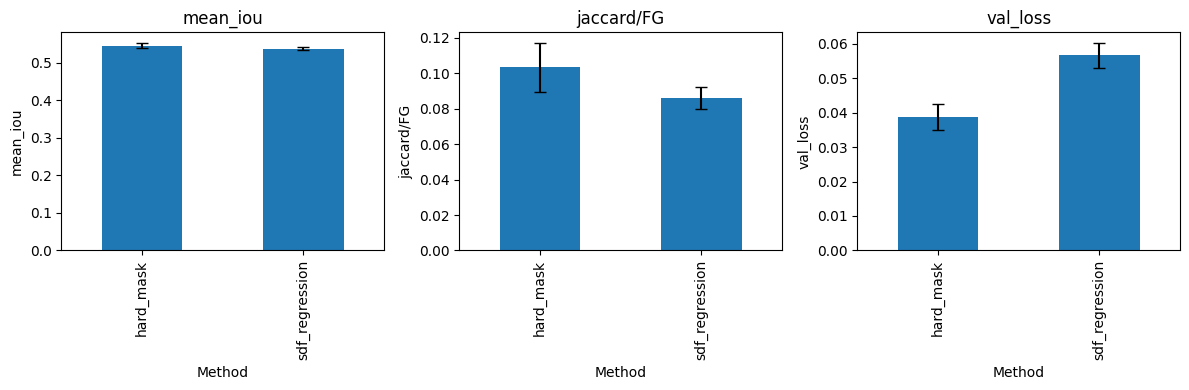

In [ ]:
RUN_FULL_COMPARISON = True
BASELINE_EPOCHS = 10
SDF_EPOCHS = 10

if RUN_FULL_COMPARISON:
    baseline_cfg = Cfg(num_epochs=BASELINE_EPOCHS, train_bs=2, val_bs=2)
    sdf_cfg = CfgSDFRegression(num_epochs=SDF_EPOCHS, train_bs=2, val_bs=2)

    comparison_df = run_baseline_vs_sdf(folds, baseline_cfg, sdf_cfg)
    summary_df = summarize_comparison(comparison_df)

    artifacts_dir = Path("project/artifacts")
    artifacts_dir.mkdir(parents=True, exist_ok=True)

    comparison_csv = artifacts_dir / "baseline_vs_sdf_folds.csv"
    summary_csv = artifacts_dir / "baseline_vs_sdf_summary.csv"
    summary_md = artifacts_dir / "baseline_vs_sdf_summary.md"
    plot_path = artifacts_dir / "baseline_vs_sdf_metrics.png"

    comparison_df.to_csv(comparison_csv, index=False)
    summary_df.to_csv(summary_csv)
    summary_df.to_markdown(summary_md)

    plot_comparison(summary_df, plot_path)
    display(comparison_df)
    display(summary_df)